In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

In [2]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [3]:
train = pd.read_csv("datasets/test.csv")
sub = pd.read_csv("datasets/submission.csv")
best = pd.read_csv("best_sub.csv")

In [4]:
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'İLÇE','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'İLÇE','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['İLÇE']=ilce_nufus['İLÇE'].apply(unidecode).str.lower()

train['İL'] = train['İL'].apply(unidecode).str.lower()
train['İLÇE'] = train['İLÇE'].apply(unidecode).str.lower()

train=pd.merge(train,ilce_nufus,on=['İLÇE'],how='left')

train["ilce_nufus"] = train["ilce_nufus"].astype(float)


In [5]:
train["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["BAŞLAMA_TARİHİ_VE_ZAMANI"],dayfirst=True)
train["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["SONA_ERME_TARİHİ_VE_ZAMANI"],dayfirst=True)

In [6]:
train["baslama_hour"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.hour
train["baslama_day"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.day
train["baslama_dayofweek"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["baslama_dayofyear"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week



train["bitis_hour"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.hour
train["bitis_day"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.day
train["bitis_dayofweek"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["bitis_dayofyear"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week


C:\Users\talha\AppData\Local\Temp\ipykernel_4800\3980600604.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
C:\Users\talha\AppData\Local\Temp\ipykernel_4800\3980600604.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week


In [7]:
train["KESİNTİ_SÜRESİ_DK"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"] - train["BAŞLAMA_TARİHİ_VE_ZAMANI"]
train['KESİNTİ_SÜRESİ_DK'] = train['KESİNTİ_SÜRESİ_DK'].dt.total_seconds()/60

In [8]:
train.drop("KADEME",axis=1,inplace=True)
train.drop("ŞEBEKE_UNSURU_KODU",axis=1,inplace=True)
train.drop("KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA",axis=1,inplace=True)
train.drop("BİLDİRİME_GÖRE",axis=1,inplace=True)
train.drop(["BAŞLAMA_TARİHİ_VE_ZAMANI","SONA_ERME_TARİHİ_VE_ZAMANI"],axis=1,inplace=True)
train.drop("KESİNTİ_NO",axis=1, inplace=True)
train.drop("OutageID",axis=1,inplace=True)
train.drop("KESİNTİ_SÜRESİ", axis=1, inplace=True)
train.drop("SÜREYE_GÖRE", axis=1, inplace=True)

In [9]:
train["SEBEBE_GÖRE"][train["SEBEBE_GÖRE"] == "0"] = "Dışsal"

C:\Users\talha\AppData\Local\Temp\ipykernel_4800\1117417988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["SEBEBE_GÖRE"][train["SEBEBE_GÖRE"] == "0"] = "Dışsal"


In [10]:

rare_labels = ['AG Fideri', 'Abone Tesisi', 'Saha Dağıtım Kutusu (SDK)']
train["ŞEBEKE_UNSURU"] = np.where(train["ŞEBEKE_UNSURU"].isin(rare_labels), 'Rare', train["ŞEBEKE_UNSURU"])


In [11]:
num_cols = ['KENTSEL_OG',
 'KENTSEL_AG',
 'KENTALTI_OG',
 'KENTALTI_AG',
 'KIRSAL_OG',
 'KIRSAL_AG',
 'TOPLAM_KENTSEL_OG',
 'TOPLAM_KENTSEL_AG',
 'TOPLAM_KENTALTI_OG',
 'TOPLAM_KENTALTI_AG',
 'TOPLAM_KIRSAL_OG',
 'TOPLAM_KIRSAL_AG',
 'ilce_nufus',
 'baslama_hour',
 'baslama_day',
 'baslama_dayofyear',
 'baslama_dayofweek',
 'baslama_week',
 'bitis_hour',
 'bitis_day',
 'bitis_dayofyear',
 'bitis_dayofweek',
 'bitis_week',
 'KESİNTİ_SÜRESİ_DK']

In [12]:
X_scaled = RobustScaler().fit_transform(train[num_cols])
train[num_cols] = pd.DataFrame(X_scaled, columns=train[num_cols].columns)

In [13]:
train = pd.get_dummies(train,drop_first=True)

In [14]:
model = joblib.load("v14_lgbm.pkl")
preds = model.predict(train)
preds = pd.Series(preds)
preds = preds.apply(lambda x  : 0  if x < 0 else x)

sub["cagri_count"] = round(preds)

In [15]:
sub.to_csv("submission.csv",index=False)

In [16]:
round(best["cagri_count"]).sum()

157893.0

In [18]:
round(sub["cagri_count"]).sum()

158153.0

In [17]:
train["cagri_count"] = round(preds)

<AxesSubplot:>

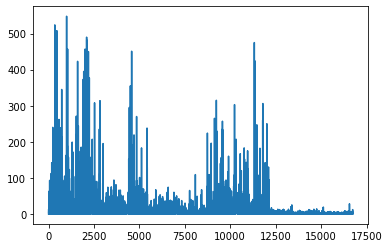

In [19]:
sub["cagri_count"].plot()

<AxesSubplot:>

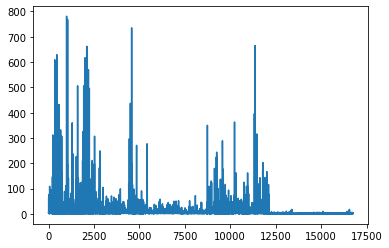

In [20]:
best["cagri_count"].plot()

<AxesSubplot:>

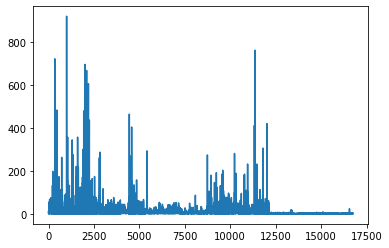

In [65]:
sub["cagri_count"].plot()

<AxesSubplot:>

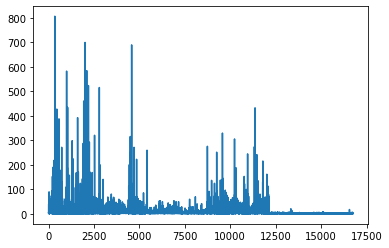

In [53]:
sub["cagri_count"].plot()

<AxesSubplot:>

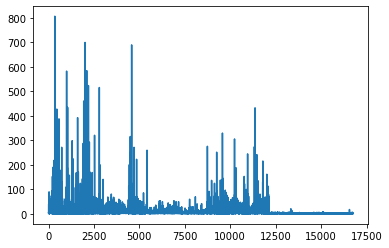

In [22]:
sub["cagri_count"].plot()

<AxesSubplot:>

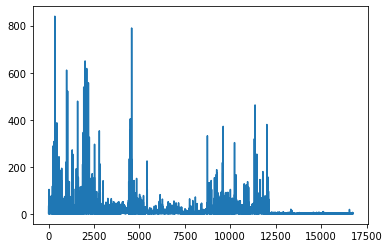

In [15]:
sub["cagri_count"].plot()

<AxesSubplot:>

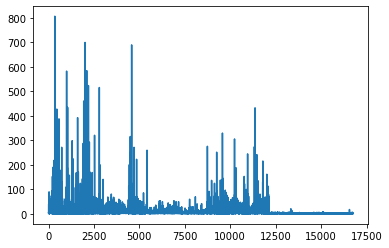

In [201]:
sub["cagri_count"].plot() #lgbm

<AxesSubplot:>

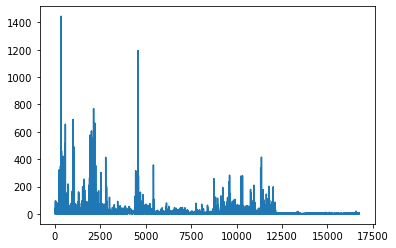

In [190]:
sub["cagri_count"].plot() # catboost